<div style="direction:rtl;line-height:300%;text-align:justify;" align="justify"><font face="B nazanin" size=4>
    <b style="font-size: 35px">خوشه‌بندی</b><br>
</font></div>

<div style="direction:rtl;line-height:300%;"><font face="XB Zar" size=3>
در این سوال قصد داریم دو الگوریتم kmeans و GMM را پیاده‌سازی کنیم. برای پیاده‌سازی این دو الگوریتم از کتابخانه‌های آماده پایتون که این دو الگوریتم در آن‌ها پیاده‌سازی شده‌اند استفاده نکنید. از این پیاده‌سازی در حل سوال‌های زیر استفاده کنید.

الگوریتم kmeans تا زمانی ادامه یابد که مرکز خوشه‌ها تغییر نکند و GMM نیز تا زمانی که اختلاف دو لگاریتم likelihood متوالی کمتر از 0.1 شود، ادامه یابد و مراکز اولیه GMM را مراکزی درنظر بگیرید که پس از اجرای الگوریتم kmeans به دست می‌آورید.
</font>
</div>

In [43]:
import math
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

- # K-Means

In [3]:
class KMeans:
    def __init__(self, cluster_count, max_iteration, run_count):
        self.k = cluster_count
        self.max_iter = max_iteration
        self.run_count = run_count
        self.centroids = None
    
    def get_random_centroids(self, x):
        return x[np.random.randint(len(x), size=self.k), :]

    def should_stop(self, old_centroids, centroids, iterations):
        return iterations > self.max_iter or (old_centroids == centroids).all()
    
    def get_distance(self, x, y):
        return np.linalg.norm(x-y)
    
    def get_labels(self, x_arr, centroids):
        return np.array([np.argmin(np.array([self.get_distance(x, centroids[i]) for i in range(self.k)])) for x in x_arr])

    def get_centroids(self, x_arr, labels):
        new_centroids, new_centroids_cnt = np.zeros((self.k, x_arr[0].shape[0])), np.zeros(self.k)
        for x_i in range(len(x_arr)):
            new_centroids[labels[x_i]] += x_arr[x_i].flatten()
            new_centroids_cnt[labels[x_i]] += 1
            
        return new_centroids / new_centroids_cnt[:, None]

    def single_run(self, x):
        centroids = self.get_random_centroids(x)
        old_centroids = None
        iter_count = 0
        while not self.should_stop(old_centroids, centroids, iter_count):
            old_centroids = centroids
            centroids = self.get_centroids(x, self.get_labels(x, centroids))
            iter_count += 1
        
        return centroids
    
    def fit(self, x):
        centroids_arr = [self.single_run(x) for _ in range(self.run_count)]
        self.centroids = centroids_arr[np.argmin(np.array([self.SSE(x, c) for c in centroids_arr]))]
        
        return self.get_labels(x, self.centroids)
            
    def SSE(self, x, centroids):
        labels = self.get_labels(x, centroids)
        
        return sum([np.linalg.norm(x[i]-centroids[labels[i]])**2 for i in range(len(x))])

- # GMM

In [66]:
class GaussianMixtureModel:
    def __init__(self, K, stop_threshold=0.1, use_k_means_initializer=True, random_state=None):
        self.K = K
        self.th = stop_threshold
        self.use_k_means_initializer = use_k_means_initializer
        self.Pi = None
        self.Mu = None
        self.Sigma = None
    
    def _init_random_params(self, X):
        raise Exception("TODO : Complete this method")
    
    def _init_params_by_kmeans(self, X):
        kmeans = KMeans(cluster_count=self.K, max_iteration=math.inf, run_count=5)
        labels = kmeans.fit(X)
        
        self.Pi = np.bincount(labels)/labels.shape[0]
        self.Mu = kmeans.centroids
        self.Sigma = np.array([np.cov(X[np.where(labels==i)].T) for i in range(self.K)])
        
    def _init_params(self, X):
        if self.use_k_means_initializer:
            self._init_params_by_kmeans(X)
        else:
            self._init_random_params(X)
    
    def _calc_nmat(self, X):
        Nmat = np.zeros((X.shape[0], self.K))
        for i in range(X.shape[0]):
            for k in range(self.K):
                exp_val = np.exp(-0.5*((X[i] - self.Mu[k]) @ np.linalg.inv(self.Sigma[k]) @ (X[i] - self.Mu[k]).T))
                Nmat[i, k] = exp_val/(np.sqrt(np.linalg.det(self.Sigma[k])) * (2*np.pi)**(X.shape[1]/2))
                
        return Nmat
    
    def _Estep(self, X):
        nmat_pi = self._calc_nmat(X) * self.Pi
        return nmat_pi/np.reshape(np.sum(nmat_pi, axis=1), (X.shape[0], 1))
    
    def _Mstep(self, X, Gam):
        Nk = np.sum(Gam, axis=0)
        self.Mu = Gam.T @ X / np.reshape(Nk, (self.K, 1))
        self.Pi = Nk/X.shape[0]
        self.Sigma.fill(0)
        for k in range(self.K):
            for i in range(X.shape[0]):
                diff = np.reshape((X[i] - self.Mu[k]), (X.shape[1], 1))
                self.Sigma[k] += Gam[i, k] * (diff @ diff.T)
            self.Sigma[k] /= Nk[k]
    
    def calc_prob_density(self, X):
        return self._calc_nmat(X) @ self.Pi
    
    def calc_log_likelihood(self, X):
        return np.sum(np.log(self.calc_prob_density(X)))
    
    def fit(self, X):
        self._init_params(X)
        log_likelihood = -np.inf 
        while True:
            self._Mstep(X, self._Estep(X))
            log_likelihood_old, log_likelihood = log_likelihood, self.calc_log_likelihood(X)
            if abs(log_likelihood - log_likelihood_old) < self.th:
                break
        
        return self
    
    def predict(self, X):
        return np.argmax(self._Estep(X), axis=1)

<div style="direction:rtl;line-height:200%;">
    <font face="XB Zar" size=3>
الف:
با استفاده از تابع زیر دیتاست را ایجاد کنید سپس با تعداد k=2 دو الگوریتم را روی دیتاست اجرا کنید. در روش k-means بهتر است الگوریتم را چندین بار با حالت های شروع مختلف اجرا کرده و بهترین نتیجه را انتخاب کنید.
    </font>
</div>

In [60]:
from sklearn.datasets import make_classification
X,Y = make_classification(n_samples=700, n_features=10,
                           n_informative=5, n_redundant=0,
                           n_clusters_per_class=2, n_classes=3)

In [61]:
k_means = KMeans(cluster_count=2, max_iteration=math.inf, run_count=5)
km_labels = k_means.fit(X)

In [62]:
gmm = GaussianMixtureModel(K=2, stop_threshold=0.1, use_k_means_initializer=True)
gmm_labels = gmm.fit(X).predict(X)

<div style="direction:rtl;line-height:200%;">
    <font face="XB Zar" size=3>
ب:
        کیفیت الگوریتم‌های خوشه بندی پیاده سازی شده را با استفاده از روشهای Purity و Index - Rand بدست آورید و آنها را با هم مقایسه کنید.
    </font>
</div>

In [37]:
def purity(y, y_hat):
    tmp = np.zeros((max(y)+1, max(y_hat)+1))
    for i in range(len(y)):
        tmp[y[i]][y_hat[i]] += 1

    return sum(np.amax(tmp, 0))/len(y_hat)

def adjusted_rand_index(y, y_hat):
    tp, tn, fp, fn = 0, 0, 0, 0
    for i in range(y.size):
        tmp = y[i] * 10 + y_hat[i]
        if tmp == 11:
            tp += 1
        elif tmp == 10:
            fn += 1
        elif tmp == 1:
            fp += 1
        else:
            tn += 1
    
    return (tp + tn) / (tp + fp + tn + fn)

In [63]:
pd.DataFrame(
    [
        [purity(km_labels, Y), adjusted_rand_index(km_labels, Y)],
        [purity(gmm_labels, Y), adjusted_rand_index(gmm_labels, Y)]
    ],
    columns=["K-Means", "GMM"],
    index=["Purity", "Rand Index"]
)

,K-Means,GMM
Purity,0.652857,0.685714
Rand Index,0.661429,0.671429


<div style="direction:rtl;line-height:200%;">
    <font face="XB Zar" size=3>
ج:
        با استفاده از دستورات زیر دیتاست‌های جدید ایجاد کنید و دو الگوریتم را روی آن‌ها اجرا کنید و پس از بصری‌سازی با استفاده از کتابخانه‌های آماده پایتون، نتایج خوشه‌بندی را مقایسه کنید. 

از هر کتابخانه بصری‌سازی پایتون می‌توانید استفاده کنید. تعداد خوشه‌ها را برابر ۲ بگیرید.
    </font>
</div>

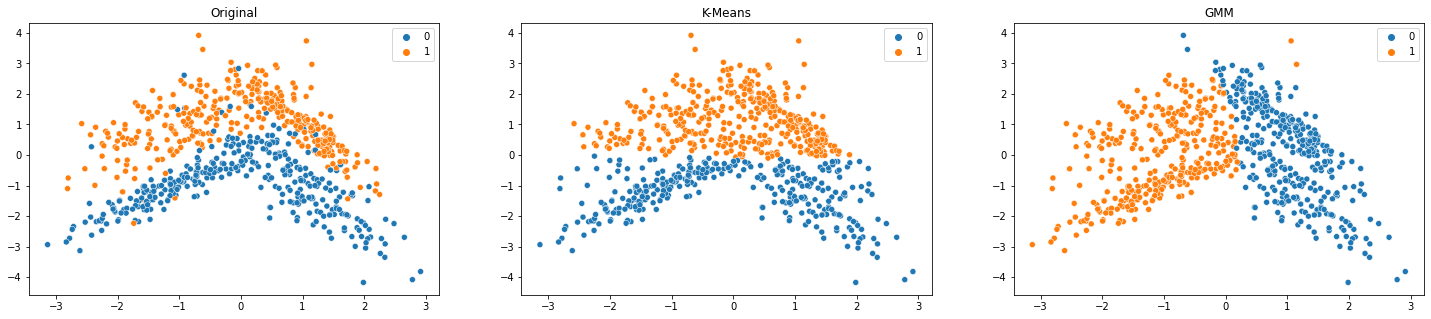

In [57]:
from sklearn.datasets import make_classification
X, Y = make_classification(n_samples=700, n_features=2,
                           n_informative=2, n_redundant=0,
                           n_classes=2)

fig, axes = plt.subplots(1, 3, figsize=(25,5))
for i, title in enumerate(["Original", "K-Means", "GMM"]):
    axes[i].set_title(title)
km_labels = KMeans(cluster_count=2, max_iteration=math.inf, run_count=5).fit(X)
gmm_labels = GaussianMixtureModel(K=2, stop_threshold=0.1, use_k_means_initializer=True).fit(X).predict(X)
sns.scatterplot(x=X[:, 0], y=X[:, 1], hue=Y, ax=axes[0])
sns.scatterplot(x=X[:, 0], y=X[:, 1], hue=km_labels, ax=axes[1]);
sns.scatterplot(x=X[:, 0], y=X[:, 1], hue=gmm_labels, ax=axes[2]);

In [58]:
pd.DataFrame(
    [
        [purity(km_labels, Y), adjusted_rand_index(km_labels, Y)],
        [purity(gmm_labels, Y), adjusted_rand_index(gmm_labels, Y)]
    ],
    columns=["K-Means", "GMM"],
    index=["Purity", "Rand Index"]
)

,K-Means,GMM
Purity,0.852857,0.852857
Rand Index,0.538571,0.461429


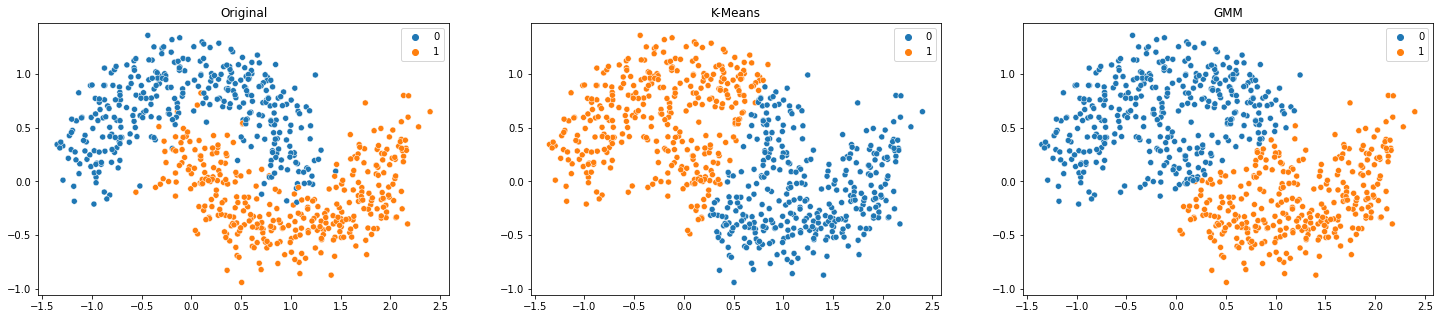

In [67]:
from sklearn.datasets import make_moons
X, Y = make_moons(n_samples=700, noise=0.2)

fig, axes = plt.subplots(1, 3, figsize=(25,5))
for i, title in enumerate(["Original", "K-Means", "GMM"]):
    axes[i].set_title(title)
    
km_labels = KMeans(cluster_count=2, max_iteration=math.inf, run_count=5).fit(X)
gmm_labels = GaussianMixtureModel(K=2, stop_threshold=0.1, use_k_means_initializer=True).fit(X).predict(X)
sns.scatterplot(x=X[:, 0], y=X[:, 1], hue=Y, ax=axes[0])
sns.scatterplot(x=X[:, 0], y=X[:, 1], hue=km_labels, ax=axes[1]);
sns.scatterplot(x=X[:, 0], y=X[:, 1], hue=gmm_labels, ax=axes[2]);

In [68]:
pd.DataFrame(
    [
        [purity(km_labels, Y), adjusted_rand_index(km_labels, Y)],
        [purity(gmm_labels, Y), adjusted_rand_index(gmm_labels, Y)]
    ],
    columns=["K-Means", "GMM"],
    index=["Purity", "Rand Index"]
)

,K-Means,GMM
Purity,0.757143,0.242857
Rand Index,0.842857,0.842857


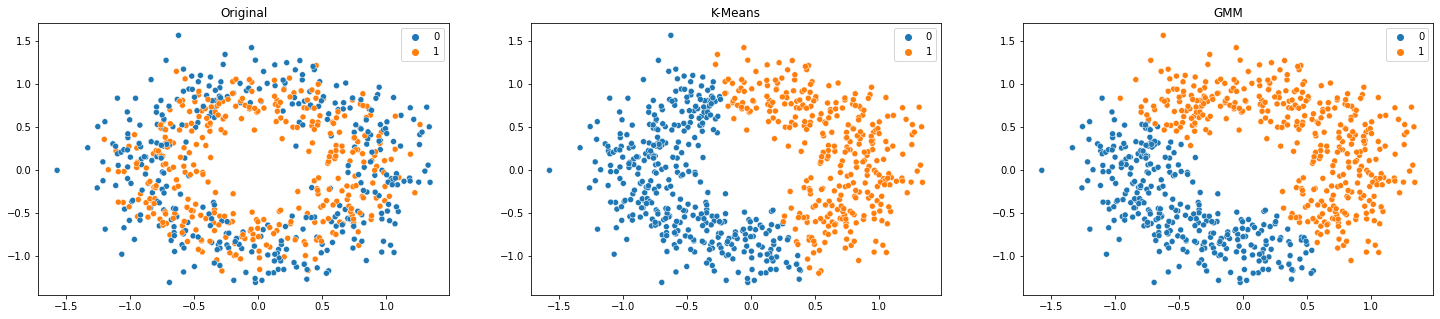

In [55]:
from sklearn.datasets import make_circles
X, Y = make_circles(n_samples=700, noise=0.2)

fig, axes = plt.subplots(1, 3, figsize=(25,5))
for i, title in enumerate(["Original", "K-Means", "GMM"]):
    axes[i].set_title(title)

km_labels = KMeans(cluster_count=2, max_iteration=math.inf, run_count=5).fit(X)
gmm_labels = GaussianMixtureModel(K=2, stop_threshold=0.1, use_k_means_initializer=True).fit(X).predict(X)
sns.scatterplot(x=X[:, 0], y=X[:, 1], hue=Y, ax=axes[0])
sns.scatterplot(x=X[:, 0], y=X[:, 1], hue=km_labels, ax=axes[1]);
sns.scatterplot(x=X[:, 0], y=X[:, 1], hue=gmm_labels, ax=axes[2]);

In [56]:
pd.DataFrame(
    [
        [purity(km_labels, Y), adjusted_rand_index(km_labels, Y)],
        [purity(gmm_labels, Y), adjusted_rand_index(gmm_labels, Y)]
    ],
    columns=["K-Means", "GMM"],
    index=["Purity", "Rand Index"]
)

,K-Means,GMM
Purity,0.530000,0.504286
Rand Index,0.557143,0.505714
